<a href="https://colab.research.google.com/github/Qwerci/Covid19-Image-Classification/blob/main/Covid_19_X_ray_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import os
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from google.colab import files

#Connecting with Kaggle and using their api

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"qwerci","key":"d823c43554981b6cfbcfcad18f64e2b3"}'}

In [5]:
os.environ["KAGGLE_CONFIG_DIR"] ="/content"

In [6]:
!kaggle datasets download -d thomasnibb/image-classification-covid19-xray


 32% 9.00M/28.3M [00:00<00:00, 34.6MB/s]
100% 28.3M/28.3M [00:00<00:00, 86.0MB/s]


## Unzip dataset into a directory

In [7]:
!unzip \*.zip -d covid_data


Archive:  image-classification-covid19-xray.zip
  inflating: covid_data/COVID19/C1.jpg  
  inflating: covid_data/COVID19/C10.jpg  
  inflating: covid_data/COVID19/C11.jpg  
  inflating: covid_data/COVID19/C12.jpg  
  inflating: covid_data/COVID19/C13.jpg  
  inflating: covid_data/COVID19/C14.jpg  
  inflating: covid_data/COVID19/C15.jpg  
  inflating: covid_data/COVID19/C16.jpg  
  inflating: covid_data/COVID19/C17.jpg  
  inflating: covid_data/COVID19/C18.jpg  
  inflating: covid_data/COVID19/C19.jpg  
  inflating: covid_data/COVID19/C2.jpg  
  inflating: covid_data/COVID19/C20.jpg  
  inflating: covid_data/COVID19/C21.jpg  
  inflating: covid_data/COVID19/C22.jpg  
  inflating: covid_data/COVID19/C23.jpg  
  inflating: covid_data/COVID19/C24.jpg  
  inflating: covid_data/COVID19/C25.jpg  
  inflating: covid_data/COVID19/C26.jpg  
  inflating: covid_data/COVID19/C27.jpg  
  inflating: covid_data/COVID19/C28.jpg  
  inflating: covid_data/COVID19/C29.jpg  
  inflating: covid_data/COVID1

Get directory content

In [10]:
for dirpath,dirname,filename in os.walk("/content/covid_data"):
  print(f"there are {len(filename)} images in '{dirpath}'.")

there are 0 images in '/content/covid_data'.
there are 30 images in '/content/covid_data/Normal'.
there are 30 images in '/content/covid_data/COVID19'.


In [11]:
data_dir = pathlib.Path("/content/covid_data")
class_name = np.array([sorted([item.name for item in data_dir.glob("*")])])
class_name

array([['COVID19', 'Normal']], dtype='<U7')

##View random Images in each directory

In [12]:
def view_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_images = random.sample(os.listdir(target_folder),2)
  print(random_images)

  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  for i, image in enumerate(random_images):
      img = mimg.imread(os.path.join(target_folder, image))
      axes[i].imshow(img, cmap="gray")
      axes[i].set_title(f"{target_class} - Image {i+1}")
      axes[i].axis("off")

  plt.show()

['C9.jpg', 'C6.jpg']


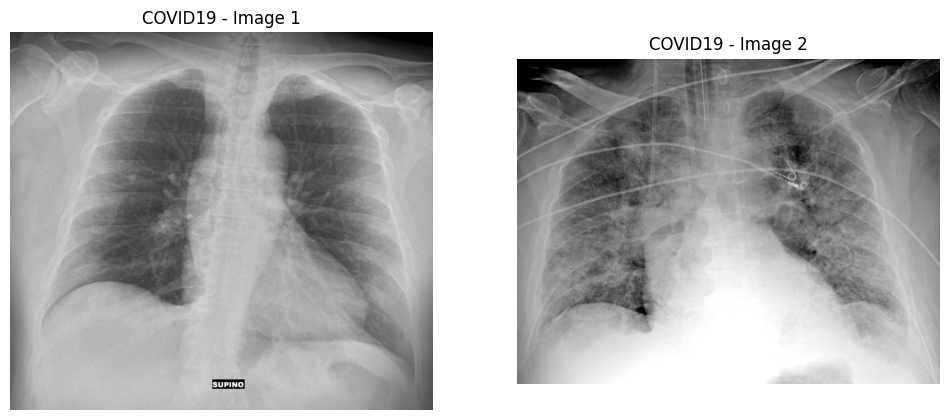

In [13]:
img = view_image("/content/covid_data/", "COVID19")

['N20.jpg', 'N10.jpg']


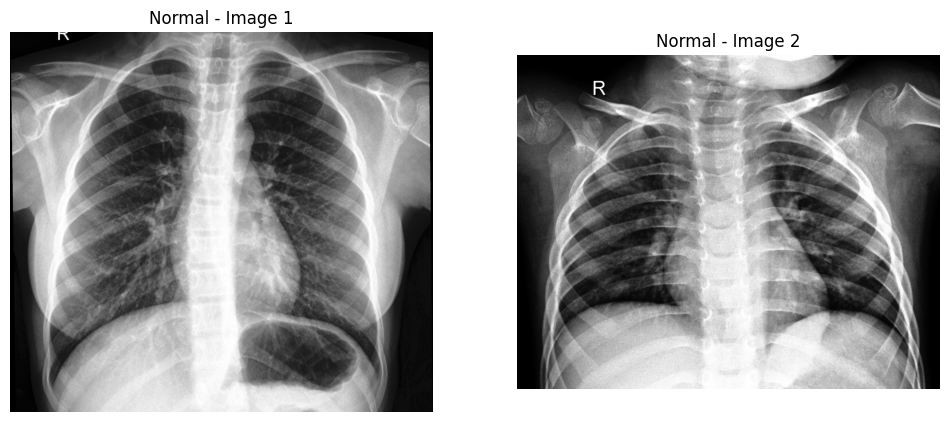

In [14]:
img = view_image("/content/covid_data/", "Normal")

##Load data into a list with their labels

In [15]:
convid19 = "/content/covid_data/COVID19"
normal = "/content/covid_data/Normal"


In [16]:
covid_files = os.listdir(convid19)
print("Number of files in 'COVID19':", len(covid_files))

# List files in the 'Normal' directory
normal_files = os.listdir(normal)
print("Number of files in 'Normal':", len(normal_files))

Number of files in 'COVID19': 30
Number of files in 'Normal': 30


##Normalize the data

In [59]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define the paths to your datasets
covid_dir = "/content/covid_data/COVID19"
normal_dir = "/content/covid_data/Normal"

# Function to load and preprocess images
def load_and_preprocess_images(directory, label):
    images = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # Ensure you're loading only image files
            img = load_img(os.path.join(directory, filename), target_size=(160, 160))
            img = img_to_array(img)
            img = img / 255.0  # Normalize pixel values

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load and preprocess COVID-19 images
covid_images, covid_labels = load_and_preprocess_images(covid_dir, 1)

# Load and preprocess normal images
normal_images, normal_labels = load_and_preprocess_images(normal_dir, 0)

# Combine the data
X = np.concatenate((covid_images, normal_images), axis=0)
y = np.concatenate((covid_labels, normal_labels), axis=0)

In [60]:
print(len(y))

60


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)



In [62]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), padding ="same", activation='relu', input_shape=(160, 160, 3)))
model.add(Conv2D(32, (3, 3), padding ="same", activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), padding ="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding ="same", activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), padding ="same", activation='relu'))
model.add(Conv2D(128, (3, 3), padding ="same", activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 160, 160, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 160, 160, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 80, 80, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 80, 80, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 80, 80, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 40, 40, 64)        0         
 g2D)                                                 

In [64]:
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/50
6/6 [==============================] - 5s 130ms/step - loss: 2.8936 - accuracy: 0.5208 - val_loss: 0.6741 - val_accuracy: 0.5833
Epoch 2/50
6/6 [==============================] - 0s 34ms/step - loss: 0.6893 - accuracy: 0.5625 - val_loss: 0.6553 - val_accuracy: 0.6667
Epoch 3/50
6/6 [==============================] - 0s 37ms/step - loss: 0.6294 - accuracy: 0.7500 - val_loss: 0.6375 - val_accuracy: 0.5000
Epoch 4/50
6/6 [==============================] - 0s 35ms/step - loss: 0.3693 - accuracy: 0.8750 - val_loss: 0.9973 - val_accuracy: 0.5000
Epoch 5/50
6/6 [==============================] - 0s 40ms/step - loss: 0.2690 - accuracy: 0.9167 - val_loss: 0.7177 - val_accuracy: 0.7500
Epoch 6/50
6/6 [==============================] - 0s 39ms/step - loss: 0.0757 - accuracy: 0.9792 - val_loss: 1.1275 - val_accuracy: 0.5833
Epoch 7/50
6/6 [==============================] - 0s 38ms/step - loss: 0.1677 - accuracy: 0.9583 - val_loss: 1.0604 - val_accuracy: 0.6667
Epoch 8/50
6/6 [==========

In [65]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


1/1 [==============================] - 1s 520ms/step - loss: 1.4361 - accuracy: 0.8333
Test loss: 1.4361368417739868, Test accuracy: 0.8333333134651184


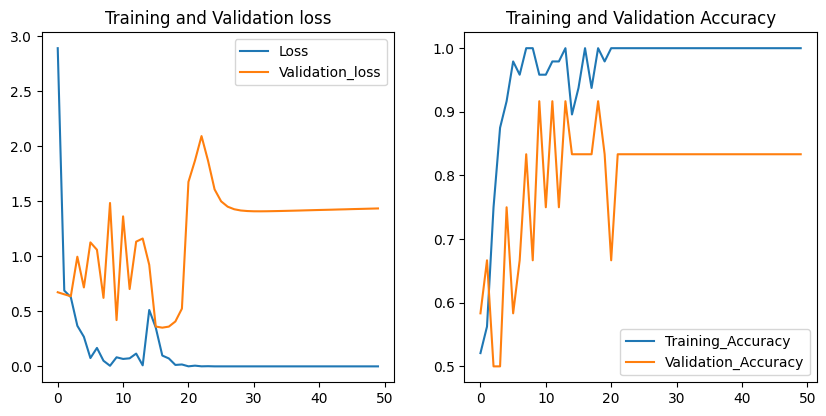

In [66]:
loss = pd.DataFrame(history.history)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss["loss"], label="Loss")
plt.plot(loss["val_loss"], label="Validation_loss")
plt.legend()
plt.title("Training and Validation loss")

plt.subplot(2, 2, 2)
plt.plot(loss["accuracy"], label="Training_Accuracy")
plt.plot(loss["val_accuracy"], label="Validation_Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()


In [67]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis =1)
y_test_new = np.argmax(np.column_stack([1 - y_test, y_test]), axis=1)


1/1 [==============================] - 0s 100ms/step


In [39]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["normal","covid"])

,normal,covid
0,7,0
1,5,0


In [69]:
base_model = tf.keras.applications.MobileNet(input_shape=[160,160,3], weights = "imagenet", include_top=False)

for layer in base_model.layers:
  layer.trainable =False

In [70]:
model = Flatten()(base_model.output)

model = Dense(units=1024, activation="relu")(model)
# model = Dense(units=512, activation="relu")(model)
model = Dense(units=256, activation="relu")(model)

prediction_layer = Dense(units=1, activation="sigmoid")(model)

In [71]:
model = Model(inputs = base_model.input, outputs = prediction_layer)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [72]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 80, 80, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 80, 80, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 80, 80, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 80, 80, 32)        128 

In [73]:
model.fit(X_train, y_train, validation_split=0.3, epochs=15, batch_size=8)

Epoch 1/15
5/5 [==============================] - 4s 274ms/step - loss: 15.2708 - accuracy: 0.6061 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 2/15
5/5 [==============================] - 0s 24ms/step - loss: 0.5179 - accuracy: 0.9091 - val_loss: 1.4257e-04 - val_accuracy: 1.0000
Epoch 3/15
5/5 [==============================] - 0s 22ms/step - loss: 0.2380 - accuracy: 0.9394 - val_loss: 2.8245 - val_accuracy: 0.8667
Epoch 4/15
5/5 [==============================] - 0s 21ms/step - loss: 0.1524 - accuracy: 0.9697 - val_loss: 2.4480e-12 - val_accuracy: 1.0000
Epoch 5/15
5/5 [==============================] - 0s 22ms/step - loss: 7.6687e-16 - accuracy: 1.0000 - val_loss: 9.2498e-12 - val_accuracy: 1.0000
Epoch 6/15
5/5 [==============================] - 0s 23ms/step - loss: 8.1834e-11 - accuracy: 1.0000 - val_loss: 1.4468e-05 - val_accuracy: 1.0000
Epoch 7/15
5/5 [==============================] - 0s 27ms/step - loss: 4.1701e-10 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.93

Text(0.5, 1.0, 'Training-Validation Accuracy')

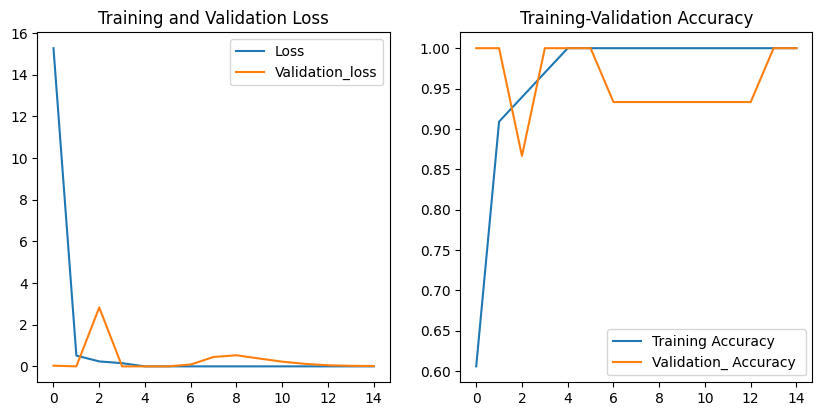

In [74]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [75]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis =1)
y_test_new = np.argmax(np.column_stack([1 - y_test, y_test]), axis=1)

1/1 [==============================] - 2s 2s/step


In [76]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["normal","covid"], index = ["normal","covid"])

,normal,covid
normal,7,0
covid,5,0
